In [1]:
%pylab inline

import bossdata.meta
import ghosts

Populating the interactive namespace from numpy and matplotlib


In [2]:
def low_z_diff(table):
    """
    Return dictionary of fibers between a pair with Z-diff <= 0.001
    
    Args:
        table(str): name of bossdata.meta.Database query table with PLATE,MJD,FIBER,Z,ZWARNING
    
    Returns:
        result({str:float}): dict with 'plate-mjd-fiber' as key, z-diff as value
    """
    result = {}
    for i in range(len(table)-1):
        if table[i]['PLATE'] == table[i+1]['PLATE']:
            if table[i]['FIBER'] == table[i+1]['FIBER'] - 2:
                diff = table[i]['Z'] - table[i+1]['Z']
                fib = table[i]['FIBER']+1
                if abs(diff) <= 0.001:
                    f_str = "{}-{}-{}".format(table[i]['PLATE'],table[i]['MJD'],fib)
                    result[f_str]={'DIFF':diff,
                                   'LOW':{'Z':table[i]['Z'],'ZWARNING':table[i]['ZWARNING']},
                                   'HIGH':{'Z':table[i+1]['Z'],'ZWARNING':table[i+1]['ZWARNING']}}
    for i in range(len(table)-2):
        if table[i]['PLATE'] == table[i+2]['PLATE']:
            if table[i]['FIBER'] == table[i+2]['FIBER'] - 2:
                diff = table[i]['Z'] - table[i+2]['Z']
                fib = table[i]['FIBER']+1
                if abs(diff) <= 0.001:
                    f_str = "{}-{}-{}".format(table[i]['PLATE'],table[i]['MJD'],fib)
                    result[f_str]={'DIFF':diff,
                                   'LOW':{'Z':table[i]['Z'],'ZWARNING':table[i]['ZWARNING']},
                                   'HIGH':{'Z':table[i+2]['Z'],'ZWARNING':table[i+2]['ZWARNING']}}
    return result

In [8]:
def valid(z_dict):
    valid = 0
    invalid = 0
    for z_diff in z_dict.keys():
        fib = int(z_diff.split('-')[2])
        if fib == 500 or fib == 501:
            invalid += 1.0
        else:
            valid += 1.0
    val = valid / len(z_dict)
    inval = invalid / len(z_dict)
    print('Valid: {} -- {:.2f}%\nInvalid: {} -- {:.2f}%'.format(int(valid), val*100, int(invalid), inval*100))

In [3]:
obj_data = bossdata.meta.Database()

In [4]:
data_table = obj_data.select_all(what = 'PLATE,MJD,FIBER,Z,ZWARNING',
                                 where = 'MJD between 55570 and 55770 and Z > 0.1',
                                 max_rows = 0)

In [5]:
x= low_z_diff(data_table)

In [9]:
valid(x)

Valid: 6361 -- 99.92%
Invalid: 5 -- 0.08%


In [56]:
def warning(z_dict):
    valid = 0
    half = 0
    invalid = 0
    for stuff in z_dict.values():
        if stuff['LOW']['ZWARNING'] == 0 and stuff['HIGH']['ZWARNING'] == 0:
            valid += 1
        elif stuff['LOW']['ZWARNING'] != 0 and stuff['HIGH']['ZWARNING'] != 0:
            invalid += 1
        else:
            half += 1
    s = "No warning: {} \nWarning: {} ({} with warning on both)"
    print(s.format(valid,half+invalid,invalid))

In [57]:
warning(x)

No warning: 6058 


In [13]:
def print_warnings(zw):
    if zw == 0:
        print('No warning')
        return
    if zw & 2**0 != 0:
        print('Sky fiber')
    if zw & 2**1 != 0:
        print('Too little wavelength coverage')
    if zw & 2**2 != 0:
        print('Small delta Chi^2')
    if zw & 2**3 != 0:
        print('Negative synthetic spectrum')
    if zw & 2**4 != 0:
        print('Too many points 5+ sigma from best model')
    if zw & 2**5 != 0:
        print('Chi^2 minimum at edge of fitting range')
    if zw & 2**6 != 0:
        print('Negative emission (QSO only)')
    if zw & 2**7 != 0:
        print('Unplugged fiber')
    if zw & 2**8 != 0:
        print('Catastrophically bad data')
    if zw & 2**9 != 0:
        print('No data')

In [10]:
test_dict = {}
for pmf in x.keys():
    plate,mjd,fiber = pmf.split('-')
    fiber = int(fiber)
    search_str = 'PLATE == {} and MJD == {} and FIBER between {} and {}'
    search_str = search_str.format(plate, mjd, fiber-1, fiber+1)
    test_table = obj_data.select_all(what = 'PLATE,MJD,FIBER,Z,ZWARNING,OBJTYPE,CLASS,SUBCLASS',
                                     where = search_str)
    test_dict[pmf] = test_table

In [30]:
def stats1(info):
    """
    """
    same_o = 0
    diff_o = 0
    same_c = 0
    diff_c = 0
    same_s = 0
    non = 0
    for key in info.keys():
        test = info[key]
        if test[0]['OBJTYPE'] == test[2]['OBJTYPE']:
            same_o += 1.0
        else:
            diff_o += 1.0
        if test[0]['CLASS'] == test[2]['CLASS']:
            same_c += 1.0
            if test[0]['SUBCLASS'] == test[2]['SUBCLASS']:
                same_s += 1
                if not test[0]['SUBCLASS'] == '""':
                    non += 1
        else:
            diff_c += 1.0
    obj_per = same_o / (same_o + diff_o)
    class_per = same_c / (same_c + diff_c)
    return (obj_per, class_per, same_s, non)

In [8]:
def stats2(info):
    """
    """
    gal = 0
    star = 0
    qso = 0
    other = 0
    for key in info.keys():
        test = info[key]
        if test[0]['CLASS'] == 'QSO':
            qso += 1
        elif test[0]['CLASS'] == 'STAR':
            star += 1
        elif test[0]['CLASS'] == 'GALAXY':
            gal += 1
        else:
            other += 1
    return (gal, star, qso, other)

In [12]:
def stats3(info):
    """
    """
    gal = 0
    star = 0
    qso = 0
    other = 0
    for key in info.keys():
        test = info[key]
        if test[1]['CLASS'] == 'QSO':
            qso += 1
        elif test[1]['CLASS'] == 'STAR':
            star += 1
        elif test[1]['CLASS'] == 'GALAXY':
            gal += 1
        else:
            other += 1
    return (gal, star, qso, other)

In [17]:
def stats4(info):
    """
    """
    low = 0
    mid = 0
    high = 0
    maybe = 0
    for key in info.keys():
        test = info[key]
        if test[1]['Z'] < 1:
            low += 1
            if test[1]['Z'] >= 0.4 and test[1]['Z'] <= 0.6:
                maybe += 1
        elif test[1]['Z'] > 3:
            high += 1
        else:
            mid += 1
    return (low, mid, high, maybe)

In [31]:
obj, cla, subc, non = stats1(test_dict)
s = "{} have same OBJTYPE \n{} have same CLASS \n{} with same SUBCLASS ({} nonempty)"
print(s.format(obj, cla, subc, non))

0.98287778825 have same OBJTYPE 
0.977065661326 have same CLASS 
6046 with same SUBCLASS (8 nonempty)


In [26]:
gal, star, qso, other = stats2(test_dict)
s = 'For first in pair: \n{} galaxies, {} stars, {} qso, {} other'
print(s.format(gal, star, qso, other))

For first in pair: 
6264 galaxies, 0 stars, 102 qso, 0 other


In [27]:
gal, star, qso, other = stats3(test_dict)
s = 'For obj in between pair: \n{} galaxies, {} stars, {} qso, {} other'
print(s.format(gal, star, qso, other))

For obj in between pair: 
3251 galaxies, 1152 stars, 1963 qso, 0 other


In [29]:
low, mid, high, maybe = stats4(test_dict)
s = '{} pairs with Z < 1 ({} with 0.4 <= Z <= 0.5) \n{} pairs with 1 <= Z <= 3 \n{} pairs with Z > 3'
print(s.format(low, maybe, mid, high))

4769 pairs with Z < 1 (1505 with 0.4 <= Z <= 0.5) 
1309 pairs with 1 <= Z <= 3 
288 pairs with Z > 3


In [19]:
1505/float(4769+1309+288)

0.23641218975808986

4620-55652-588


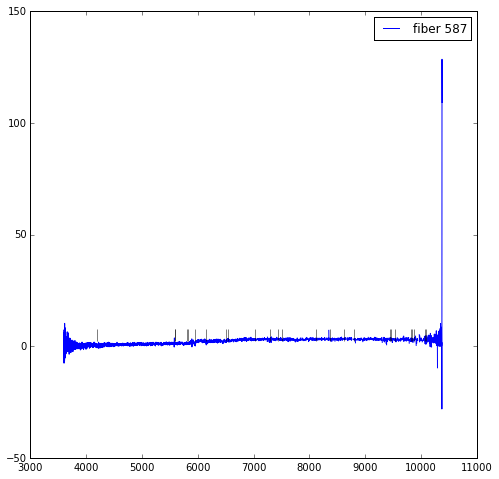

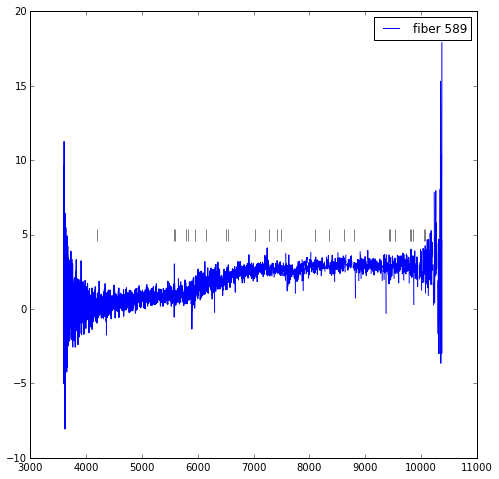



4053-55591-353


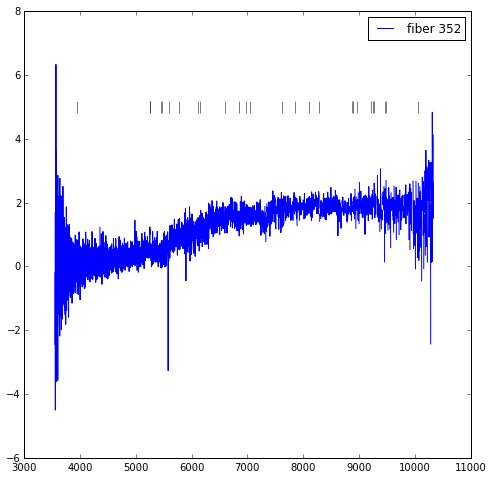

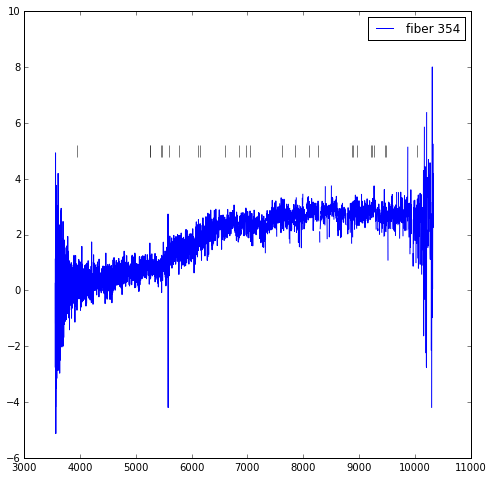



4504-55571-979


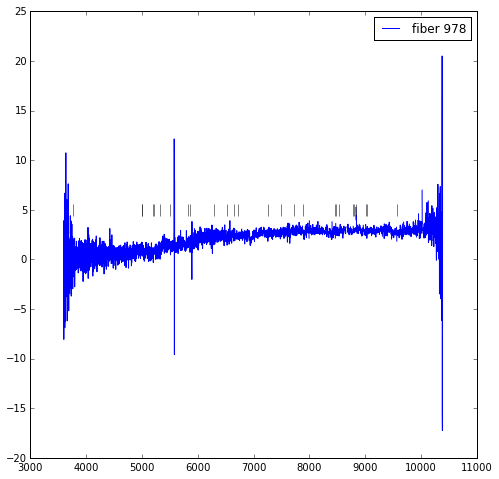

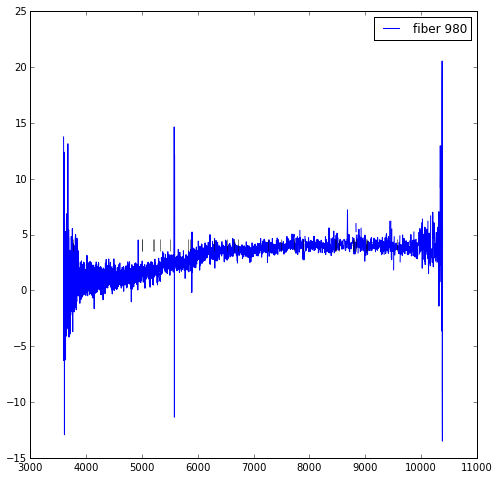



4859-55684-68


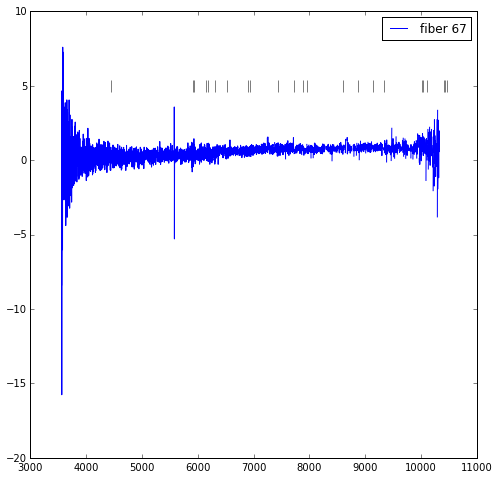

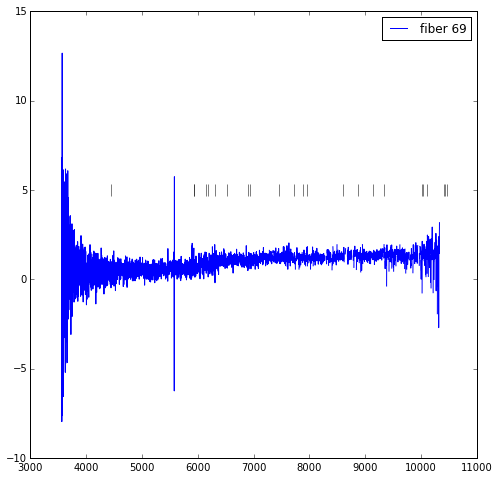



4053-55591-358


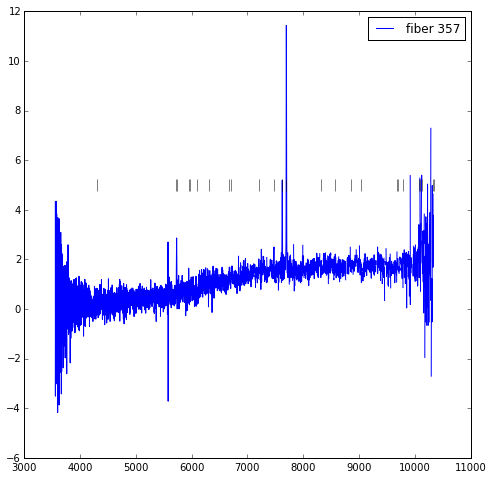

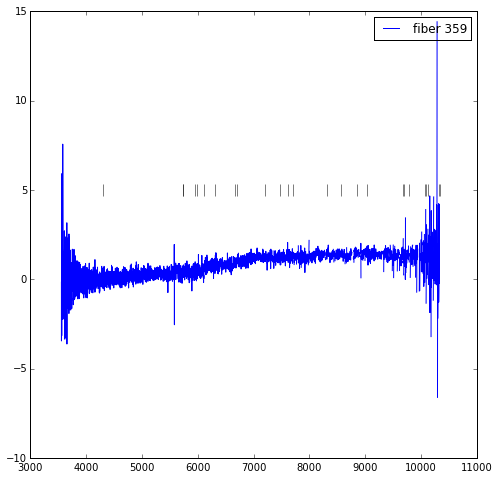



4698-55623-832


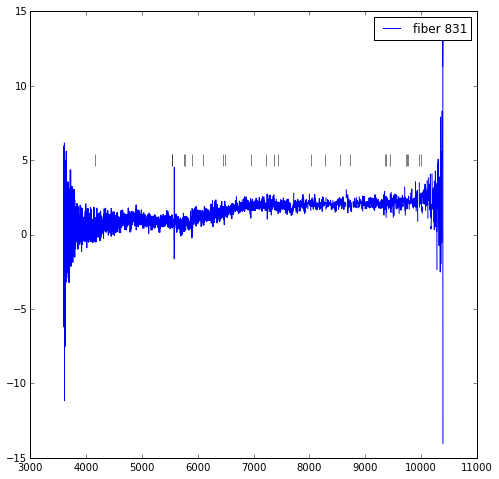

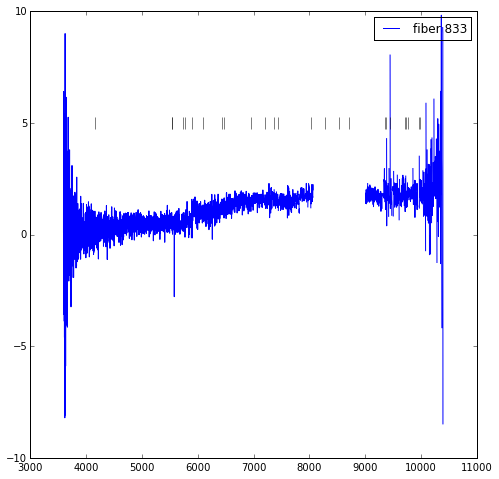



4625-55632-474


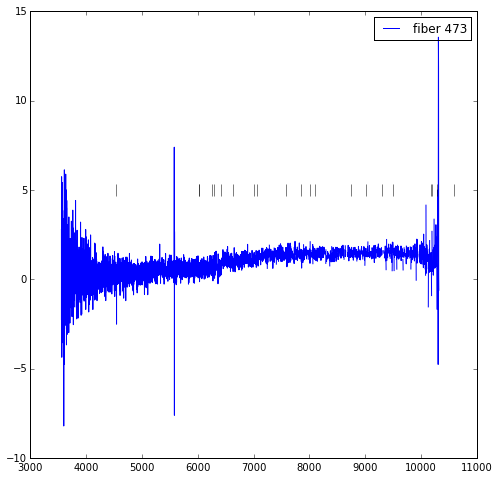

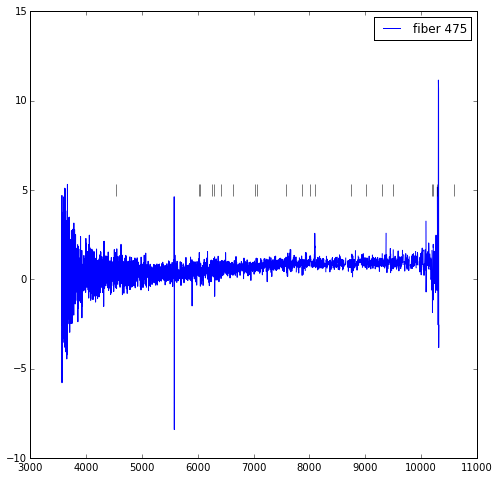



4562-55570-410


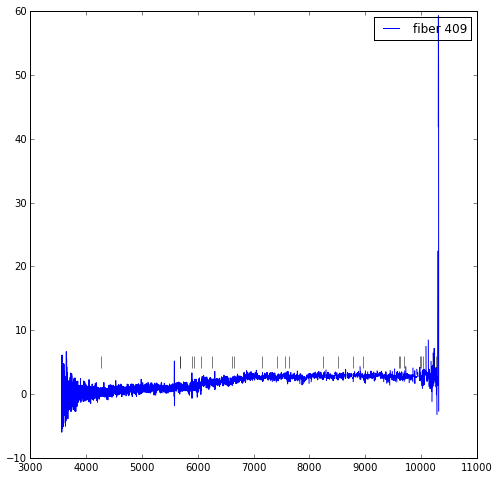

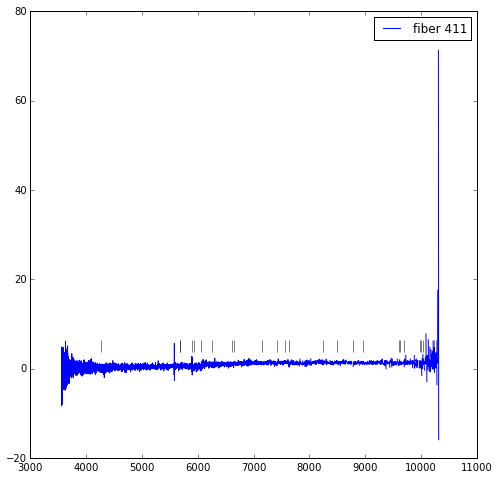



4993-55738-434


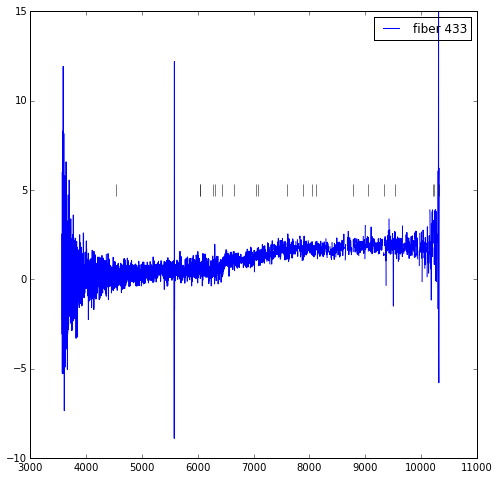

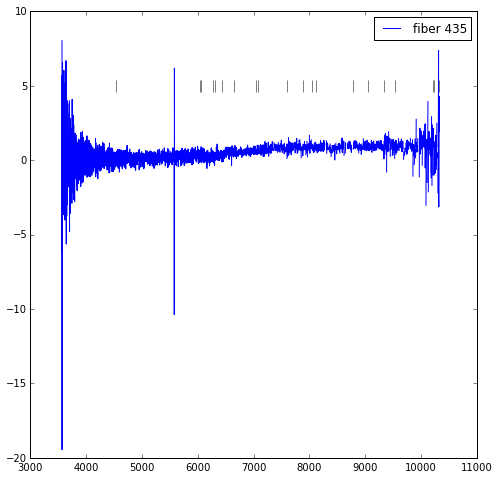



4730-55630-618


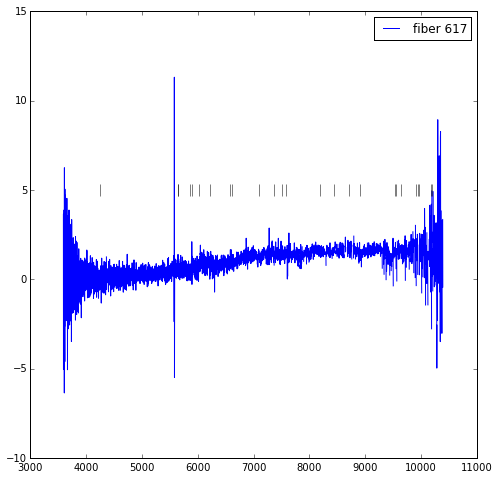

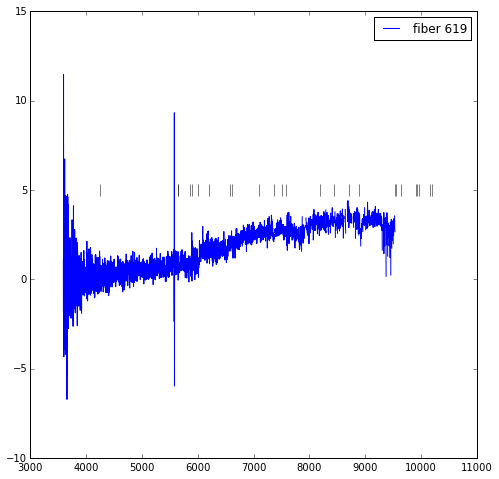



4779-55656-188


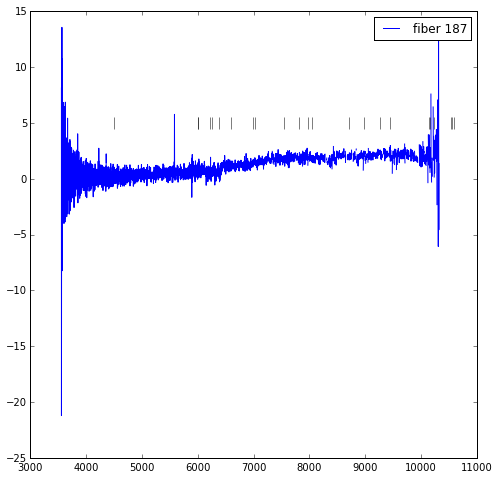

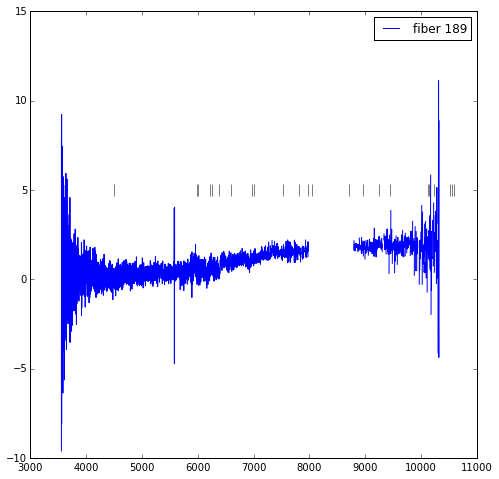



3830-55574-322


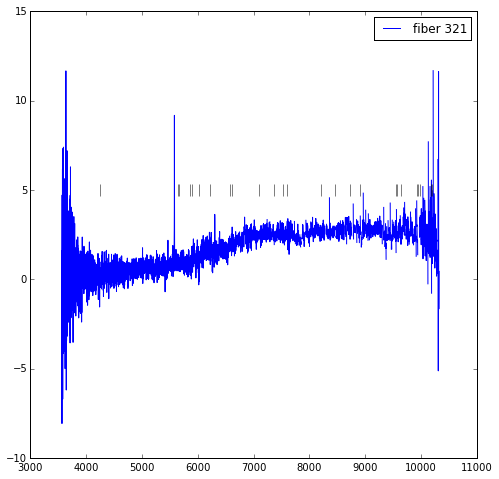

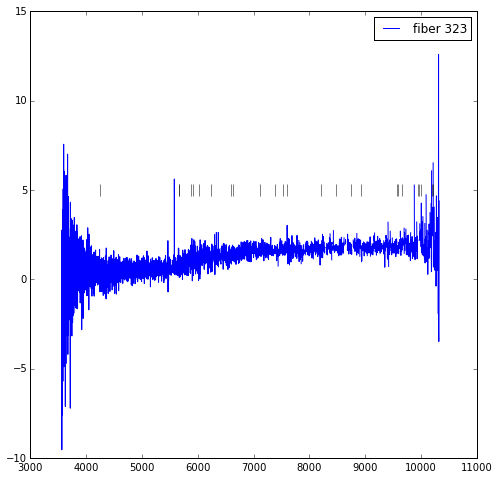



4188-55684-626


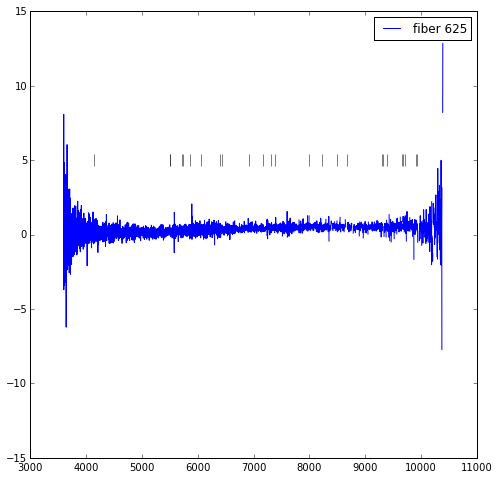

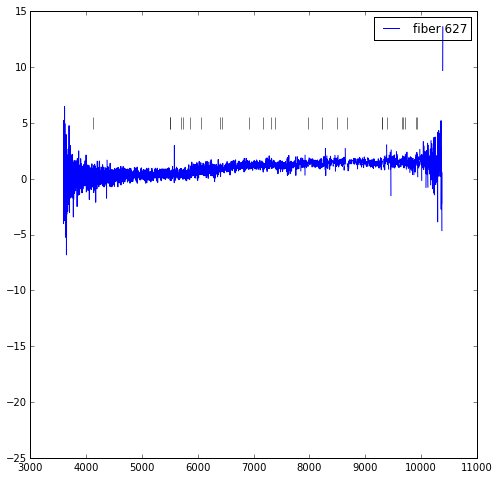



4738-55650-542


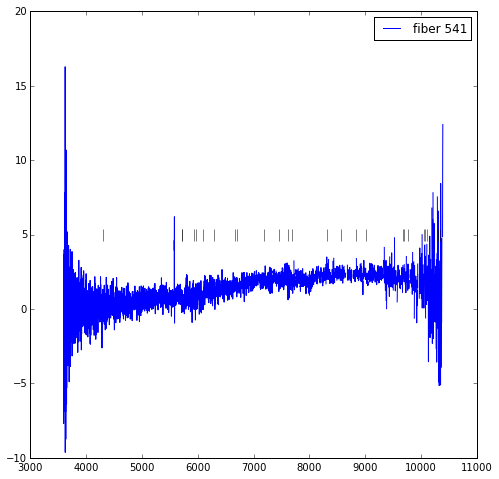

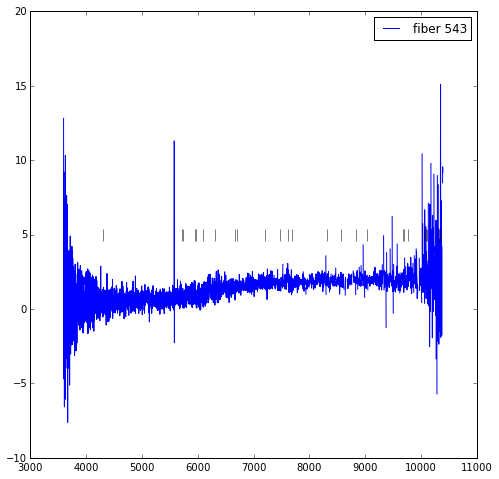



3847-55588-448


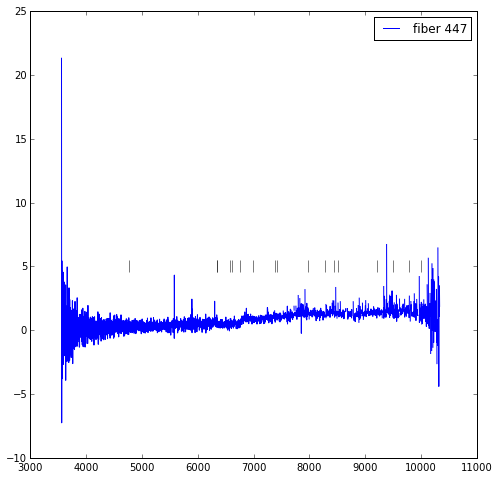

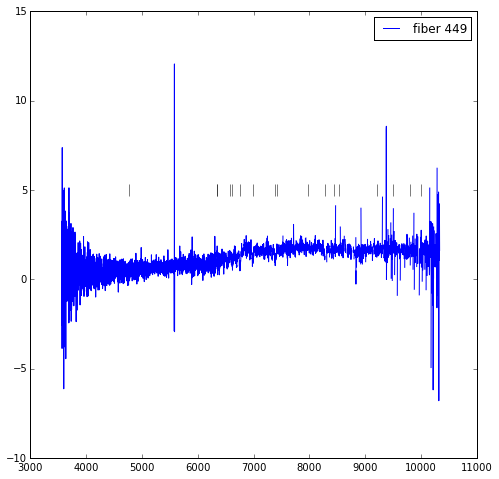



4807-55687-612


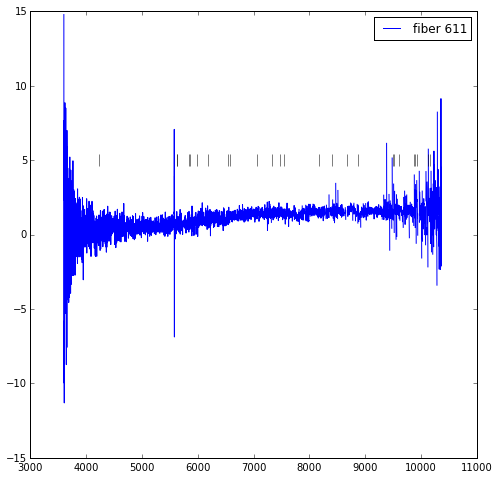

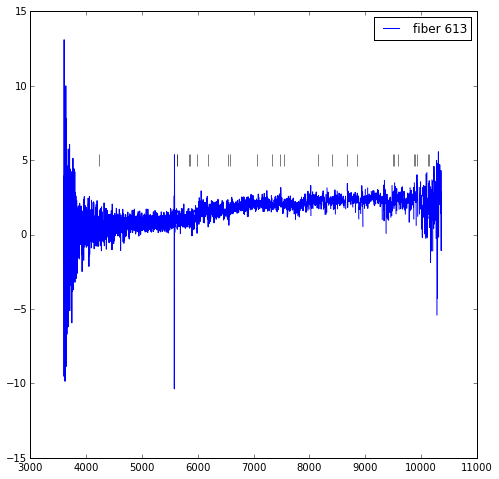



4029-55618-94


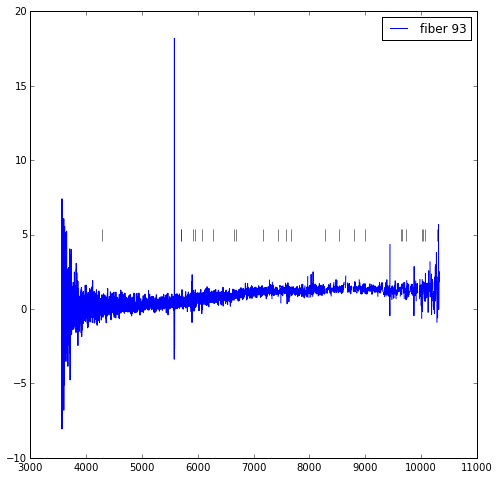

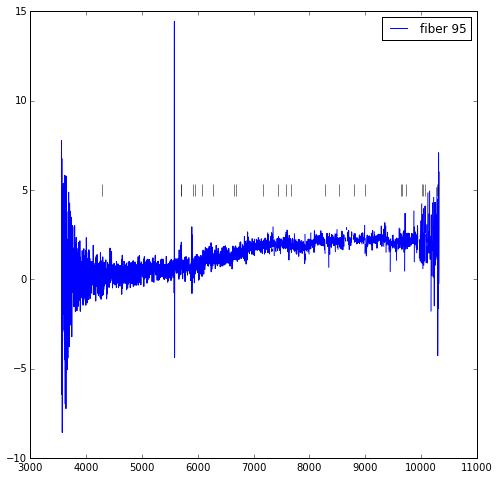



4564-55570-824


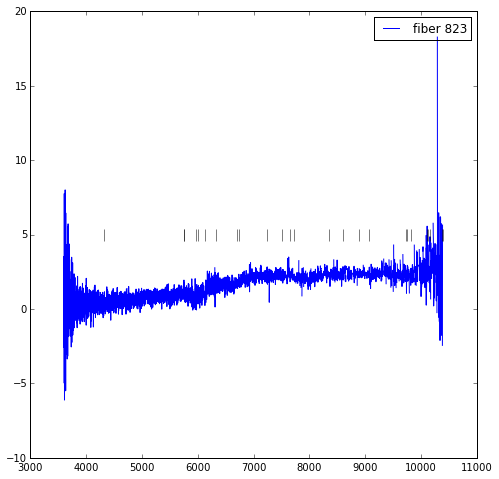

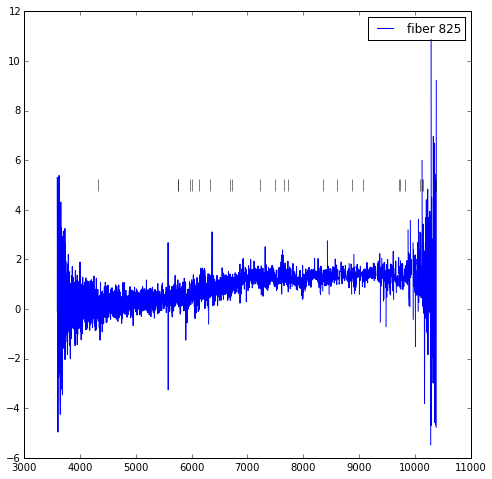



4029-55618-90


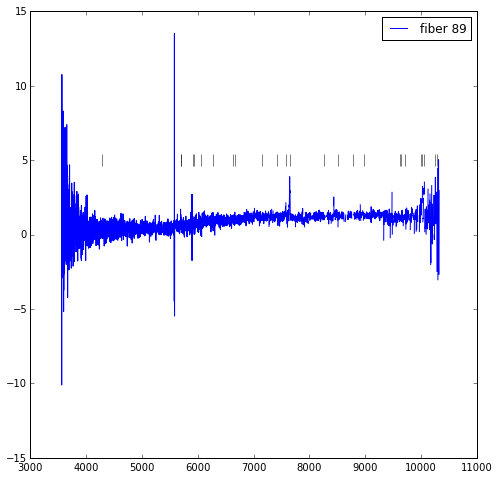

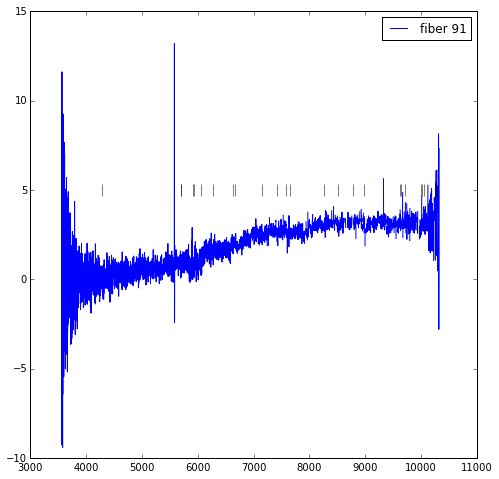



4756-55631-73


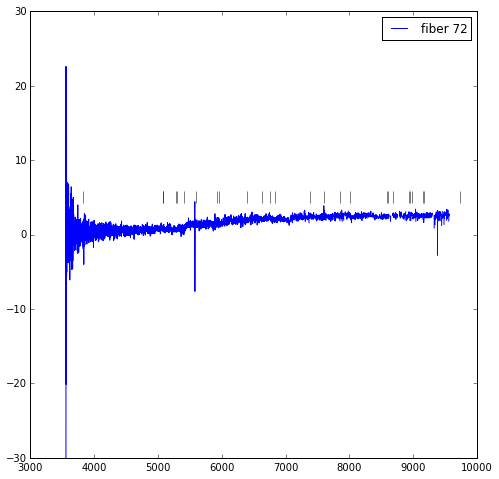

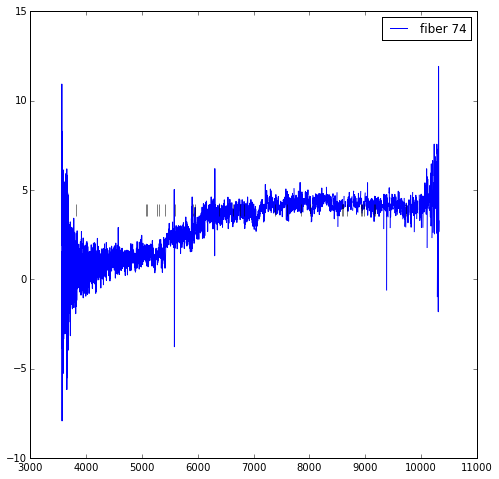

In [6]:
attempt = x.keys()[:20]
for pmf in attempt:
    plate,mjd,fiber = pmf.split('-')
    plate = int(plate)
    mjd = int(mjd)
    fiber = int(fiber)
    gs = ghosts.flux_data(plate, mjd, fiber)
    print(pmf)
    plt.figure(figsize = (8,8))
    gs.plt_low(elines = True)
    plt.figure(figsize = (8,8))
    gs.plt_high(elines = True)
    print('\n')